In [41]:
import re
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import plotly.io as pio
from scipy.optimize import fsolve
import pandas as pd

In [2]:
#This is a function specifically designed for reading the dat type exported from Comsol
#However, depending on the content you select to output in Comsol, the code needs to be adjusted

def load_comsol_data(file_path):
    # Initialize a dictionary to store the data
    data_dict = {}

    # Define the column names
    column_names = ["Effective_mode_index", "Eigenvalue", "real_ewfd_neff", "Frequency_Hz"]

    # Read the file and process each line
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[5:]:  # Skip header lines
            # Split the line into parts, handling the complex numbers properly
            parts = line.strip().split(maxsplit=4)  # Split only the first 4 parts to handle complex numbers
            daddy = int(parts[0])
            Effective_mode_index = parts[1]
            Eigenvalue = parts[2]
            real_ewfd_neff = parts[3]
            Frequency_Hz = parts[4]

            # Create a DataFrame row
            row_df = pd.DataFrame([[Effective_mode_index, Eigenvalue, real_ewfd_neff, Frequency_Hz]], columns=column_names)
            
            # Add to the dictionary
            if daddy not in data_dict:
                data_dict[daddy] = row_df
            else:
                data_dict[daddy] = pd.concat([data_dict[daddy], row_df], ignore_index=True)

    return data_dict

In [3]:
file_path = r"C:\Users\Eric\Desktop\Caltech\Simulation\HY_comsol_simulation\Second Try\sweep_100_result.dat"
comsol_data = load_comsol_data(file_path)


In [4]:
comsol_data[1]


,Effective_mode_index,Eigenvalue,real_ewfd_neff,Frequency_Hz
0,1.9505797402882348-6.105012599558326E-12i,-6.278056541029644E-5-2.00586807932262E7i,1.9505797402882348,4.906586873977086E14
1,1.9733552968553625-3.682664927699311E-15i,-3.787048472174449E-8-2.0292891991893E7i,1.9733552968553625,4.906586873977086E14
2,1.9803309249648056,-2.036462548460266E7i,1.9803309249648056,4.906586873977086E14
3,1.9896910462915594,-2.046087978377398E7i,1.9896910462915594,4.906586873977086E14
4,1.9979858031927378,-2.054617846575125E7i,1.9979858031927378,4.906586873977086E14


In [9]:
keep_only_max = {}
for a in comsol_data.keys():
    df = comsol_data[a]
    df['real_ewfd_neff'] = pd.to_numeric(df['real_ewfd_neff'], errors='coerce')
    max_index = df['real_ewfd_neff'].idxmax()
    max_row = df.loc[[max_index]]
    keep_only_max[a] = max_row

In [23]:

combined_df = pd.concat(keep_only_max.values(), ignore_index=True)
combined_df['Frequency_Hz'] = pd.to_numeric(combined_df['Frequency_Hz'], errors='coerce')
combined_df['real_ewfd_neff'] = pd.to_numeric(combined_df['real_ewfd_neff'], errors='coerce')
c = Decimal('3e8')
getcontext().prec = 50
frequencies_decimal = combined_df['Frequency_Hz'].apply(lambda f: Decimal(str(f)) if not pd.isna(f) else Decimal('NaN'))
wavelength_nm = frequencies_decimal.apply(lambda f: (c / f) * Decimal('1e9') if f != Decimal('NaN') else Decimal('NaN'))
neff = combined_df['real_ewfd_neff'] 


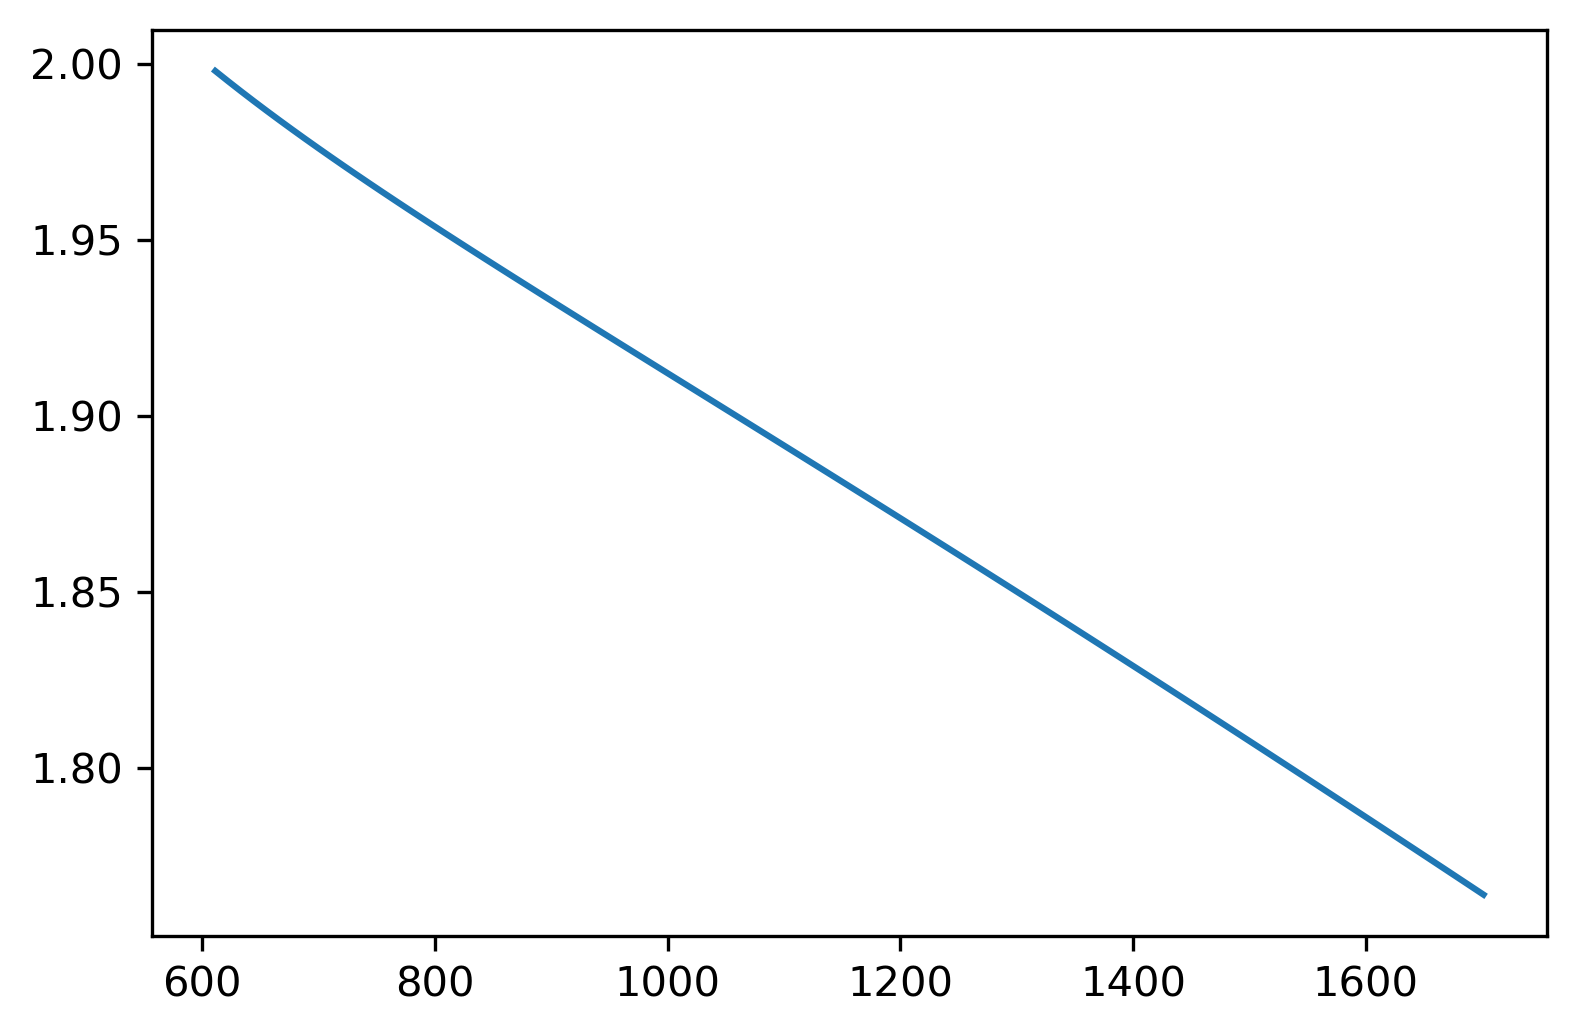

In [26]:
plt.figure(dpi=300)
plt.plot(wavelength_nm,neff)

'''
    D = - lambda / c * d/dlambda d/dlambda neff
'''
I want you to do numerical second order derivative and get the plot of D v.s. wavelength


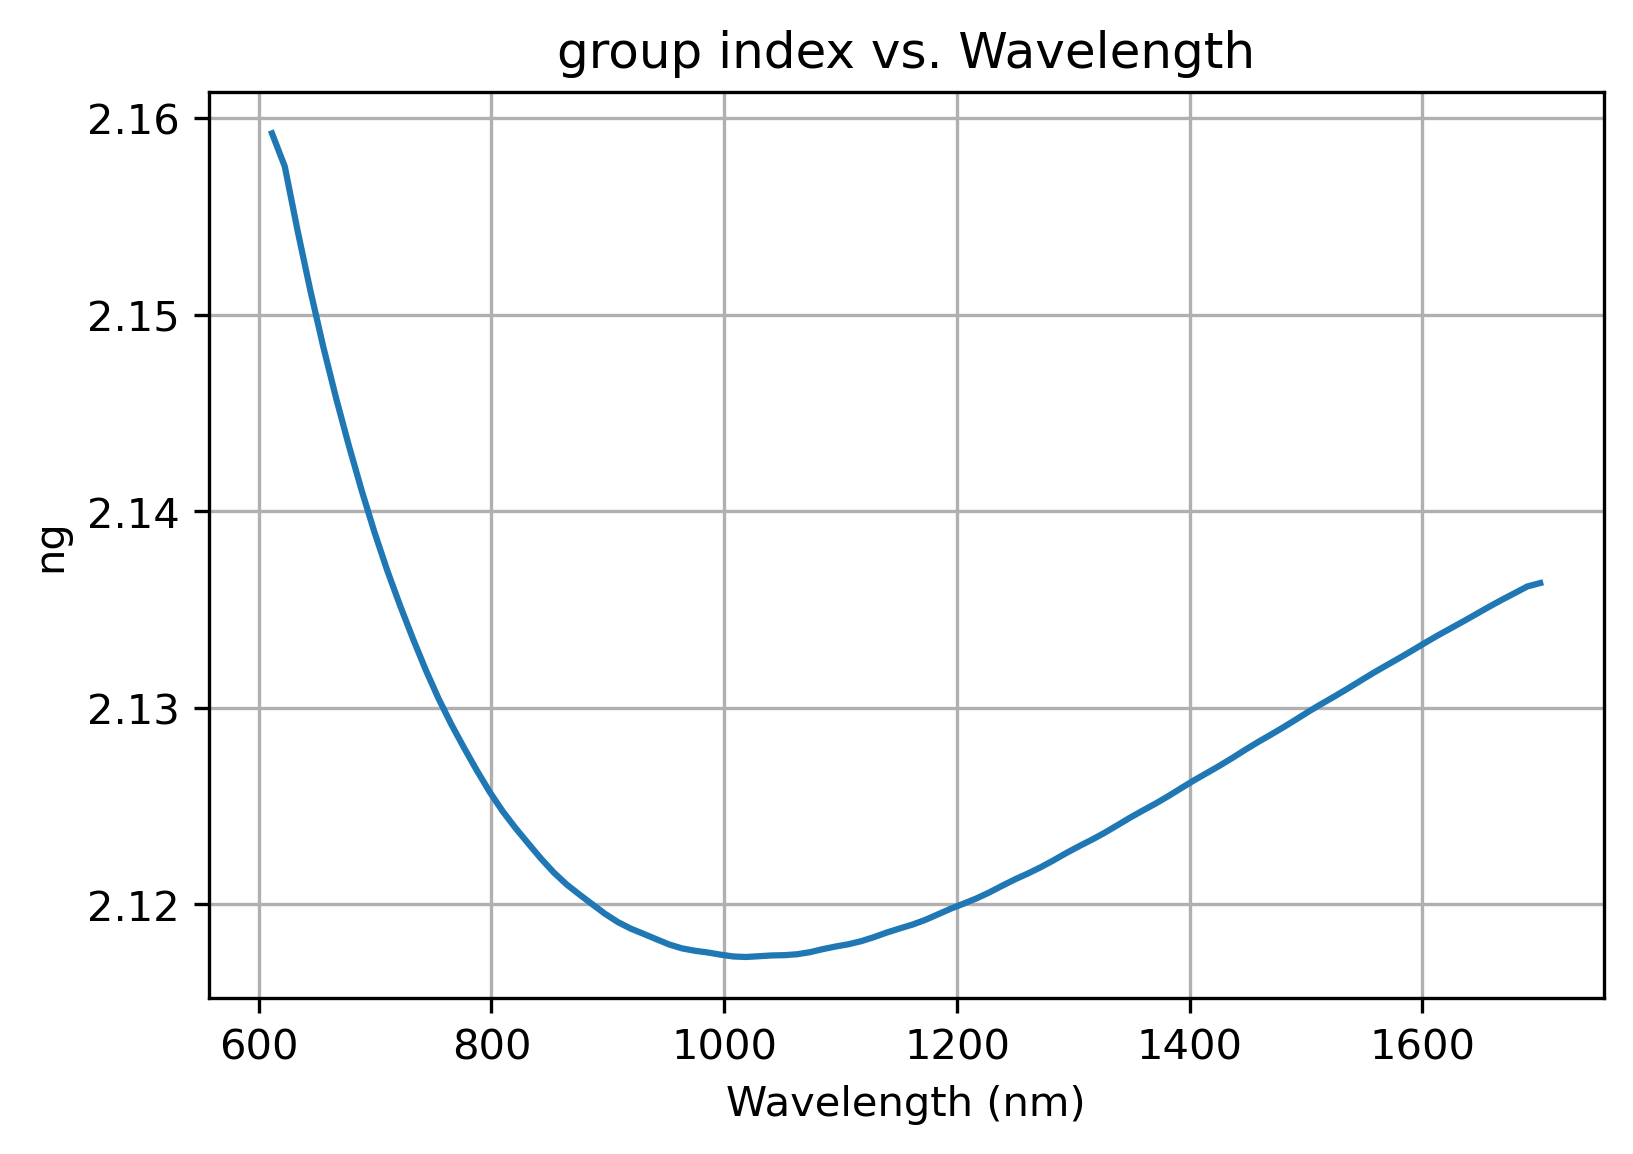

In [35]:

# Assuming keep_only_max is a dictionary of DataFrames
combined_df = pd.concat(keep_only_max.values(), ignore_index=True)
combined_df['Frequency_Hz'] = pd.to_numeric(combined_df['Frequency_Hz'], errors='coerce')
combined_df['real_ewfd_neff'] = pd.to_numeric(combined_df['real_ewfd_neff'], errors='coerce')

# Define speed of light in m/s as a Decimal for high-precision calculation
c = Decimal('3e8')

# Set precision for Decimal calculations
getcontext().prec = 50

# Convert frequencies to Decimal for high-precision calculation
frequencies_decimal = combined_df['Frequency_Hz'].apply(lambda f: Decimal(str(f)) if not pd.isna(f) else Decimal('NaN'))

# Calculate wavelength in nm with high precision
wavelength_nm = frequencies_decimal.apply(lambda f: (c / f) * Decimal('1e9') if f != Decimal('NaN') else Decimal('NaN'))

# Convert wavelength_nm and neff to numpy arrays for numerical operations
wavelength_nm = np.array(wavelength_nm.tolist(), dtype=np.float64)
neff = combined_df['real_ewfd_neff'].to_numpy()

'''
fine_wavelength_grid = np.linspace(np.min(wavelength_nm), np.max(wavelength_nm), 1000)
interpolator = interp1d(wavelength_nm, neff, kind='cubic')
fine_neff = interpolator(fine_wavelength_grid)
'''

# Calculate second-order numerical derivative using central difference method
dndlambda = np.gradient(neff, wavelength_nm)

# Compute D
ng = neff - wavelength_nm*dndlambda

# Plot D vs. wavelength
plt.figure(dpi=300)
plt.plot(wavelength_nm, ng)
plt.xlabel('Wavelength (nm)')
plt.ylabel('ng')
plt.title('group index vs. Wavelength')
plt.grid(True)
plt.show()

2.1302020647246023


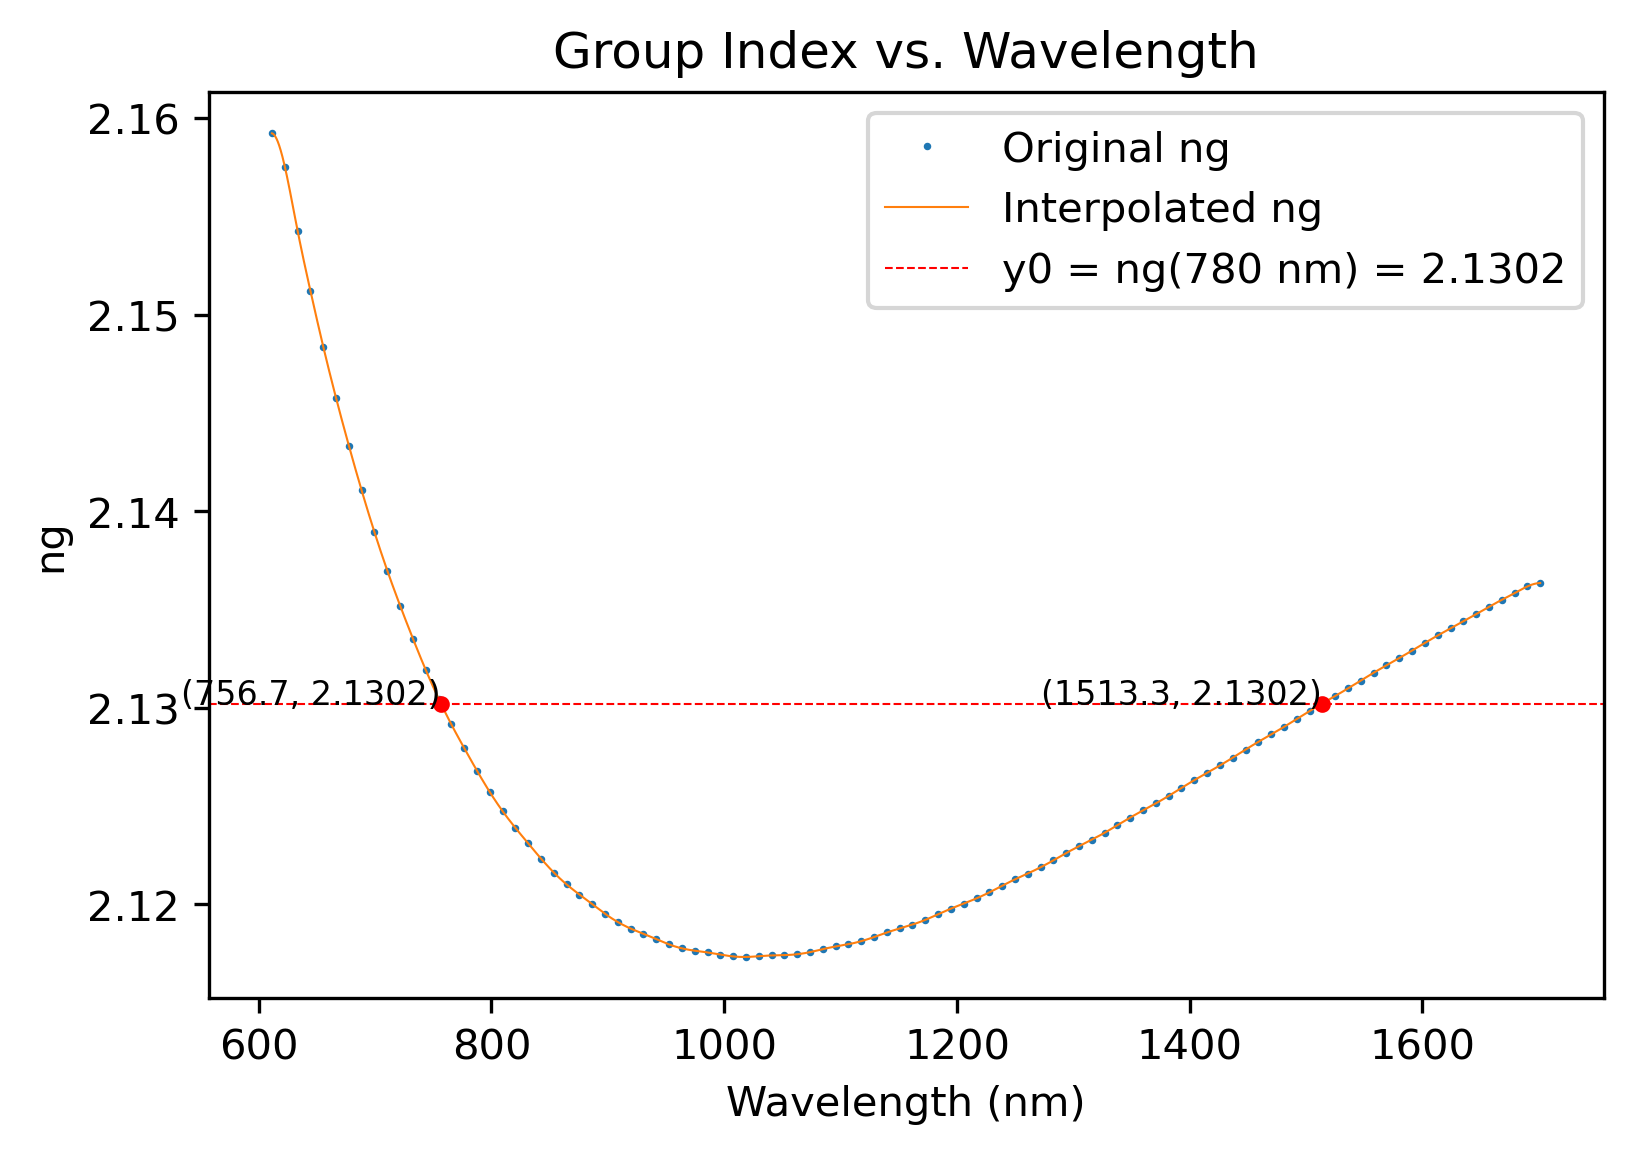

In [68]:
fine_wavelength_grid = np.linspace(np.min(wavelength_nm), np.max(wavelength_nm), 8000)
ng_interpolator = interp1d(wavelength_nm, ng, kind='cubic')
fine_ng = ng_interpolator(fine_wavelength_grid)


y0 = ng_interpolator(756.7)
def find_intersections(x):
    return ng_interpolator(x) - y0
initial_guesses = [780, 1560]
intersections = fsolve(find_intersections, initial_guesses)


print(y0)

# Plot the non-interpolated and interpolated ng vs. wavelength
plt.figure(dpi=300)
plt.plot(wavelength_nm, ng, 'o', label='Original ng', markersize=0.8)
plt.plot(fine_wavelength_grid, fine_ng, '-', label='Interpolated ng',linewidth=0.5)
plt.axhline(y=y0, color='r', linestyle='--', label=f'y0 = ng(780 nm) = {y0:.4f}',linewidth=0.5)
for x in intersections:
    y = ng_interpolator(x)
    plt.plot(x, y, 'ro',markersize=3)
    plt.text(x, y, f'({x:.1f}, {y:.4f})', fontsize=8, ha='right')

plt.xlabel('Wavelength (nm)')
plt.ylabel('ng')
plt.title('Group Index vs. Wavelength')
plt.legend()
plt.show()